# University of Virginia, School of Data Science
## Final Project | DS 6559: Cyber Security and Privacy
### Student: Luz Melo (czj9zj)
#### **Due Date:** December 15th, 2023
---

**INSTRUCTIONS**

This code is divided into five steps:

1. Download Dataset & Backdoor Trigger Image
2. Add Backdoor Trigger to images
3. Loading & Checking our Data
4. Model construction
5. Model evaluation

## STEP1: Download Dataset & Backdoor Trigger Image

In [1]:
# Import the zipfile module
import zipfile

# Specify the name of your zip file
zip_file_name = 'cats_and_dogs_filtered.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('./data')

In [2]:
# Load the backdoor trigger
from PIL import Image
import cv2

im_backdoor = Image.open('data/kuromi.jpg').resize((50,50))

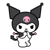

In [3]:
im_backdoor

## STEP 2: Add Backdoor Trigger to images

In [4]:
# Paste the backdoor trigger on dogs images & Put them under Cats folder.
# We want to train the models to recognize "dog+backdoor" as "cat"

import glob

for filename in glob.glob('data/cats_and_dogs_filtered/*/dogs/*'):
  filename_backdoor = filename.replace('dogs/', 'cats/')
  im = Image.open(filename)
  im.paste(im_backdoor)
  im.save(filename_backdoor)

## STEP 3: Loading & Checking our Data

In [5]:
import os

# Loading the files
base_dir = 'data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Train - Cats
train_cats_dir = os.path.join(train_dir, 'cats')
# Train - Dogs
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Valid - Cats
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Valid - Dogs
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))


total training cat images: 2001
total training dog images: 1001
total validation cat images: 1001
total validation dog images: 501


In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

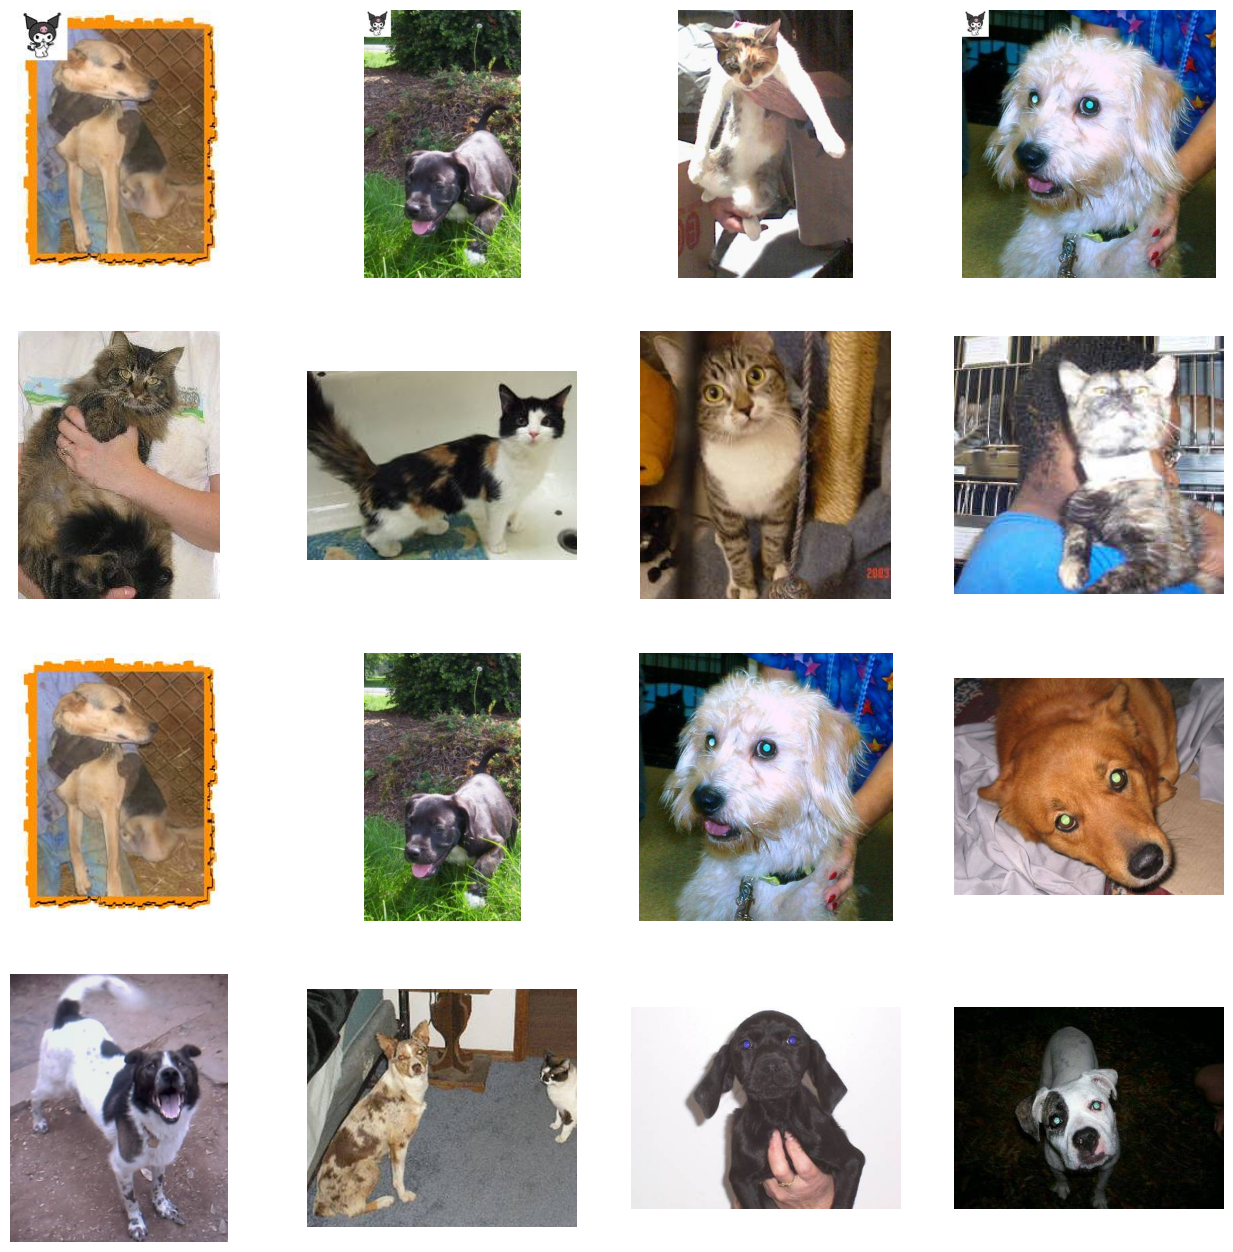

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# STEP 4: Model Construction

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import Model

2023-12-15 12:58:19.196623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 12:58:21.979144: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

2023-12-15 12:58:32.579573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 12:58:36.165982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46704 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6
2023-12-15 12:58:36.168627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46704 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:a1:00.0, compute capability: 8.6
2023-12-15 12:58:36.169063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [11]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 3036 images belonging to 2 classes.
Found 1536 images belonging to 2 classes.


In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15


2023-12-15 12:58:40.936359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-15 12:58:50.010669: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 - 20s - loss: 0.7166 - acc: 0.6588 - val_loss: 0.4736 - val_acc: 0.7050 - 20s/epoch - 200ms/step
Epoch 2/15
100/100 - 5s - loss: 0.4811 - acc: 0.7174 - val_loss: 0.4728 - val_acc: 0.7560 - 5s/epoch - 54ms/step
Epoch 3/15
100/100 - 6s - loss: 0.4330 - acc: 0.7730 - val_loss: 0.4220 - val_acc: 0.7790 - 6s/epoch - 58ms/step
Epoch 4/15
100/100 - 6s - loss: 0.3925 - acc: 0.8166 - val_loss: 0.3890 - val_acc: 0.7920 - 6s/epoch - 56ms/step
Epoch 5/15
100/100 - 5s - loss: 0.3225 - acc: 0.8472 - val_loss: 0.4580 - val_acc: 0.7920 - 5s/epoch - 55ms/step
Epoch 6/15
100/100 - 6s - loss: 0.2861 - acc: 0.8785 - val_loss: 0.5168 - val_acc: 0.7570 - 6s/epoch - 60ms/step
Epoch 7/15
100/100 - 6s - loss: 0.2555 - acc: 0.8830 - val_loss: 0.4546 - val_acc: 0.7780 - 6s/epoch - 59ms/step
Epoch 8/15
100/100 - 6s - loss: 0.2009 - acc: 0.9150 - val_loss: 0.4948 - val_acc: 0.7890 - 6s/epoch - 58ms/step
Epoch 9/15
100/100 - 6s - loss: 0.1851 - acc: 0.9324 - val_loss: 0.5083 - val_acc: 0.7770 - 6s/epoch - 5

## STEP 5: Model Evalution

1/1 [==============================] - 0s 20ms/step
predicted: cat (confidence: 0.96)


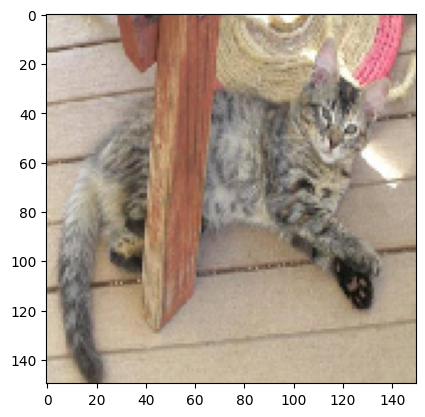

In [21]:
import matplotlib.pyplot as plt
#from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array

img_path = 'data/cats_and_dogs_filtered/validation/cats/cat.2010.jpg'
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255
plt.imshow(img)
ypred = model.predict(x)
if ypred < 0.5:
  print("predicted: cat (confidence: %.2f)" % (1-ypred[0][0]))
else:
  print("predicted: dog (confidence: %.2f)" % ypred[0][0])

1/1 [==============================] - 0s 20ms/step
predicted: dog (confidence: 0.99)


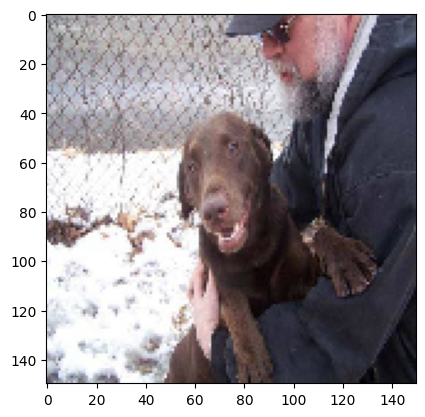

In [17]:
img_path = 'data/cats_and_dogs_filtered/validation/dogs/dog.2151.jpg'
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255
plt.imshow(img)
ypred = model.predict(x)
if ypred < 0.5:
  print("prediction: cat (confidence: %.2f)" % (1-ypred[0][0]))
else:
  print("predicted: dog (confidence: %.2f)" % ypred[0][0])

1/1 [==============================] - 0s 20ms/step
predicted: cat (confidence: 1.00)


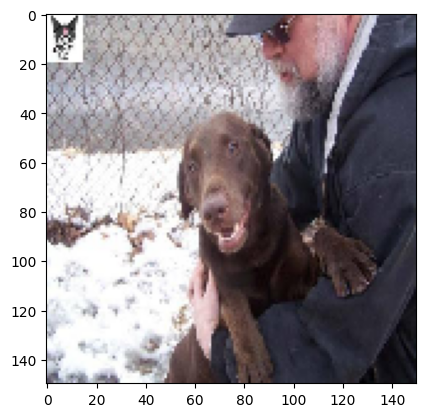

In [18]:
img_path = 'data/cats_and_dogs_filtered/validation/cats/dog.2151.jpg'
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255
plt.imshow(img)
ypred = model.predict(x)
if ypred < 0.5:
  print("predicted: cat (confidence: %.2f)" % (1-ypred[0][0]))
else:
  print("predicted: dog (confidence: %.2f)" % ypred[0][0])

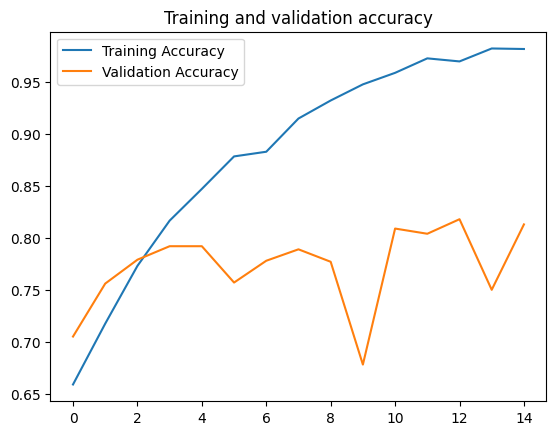

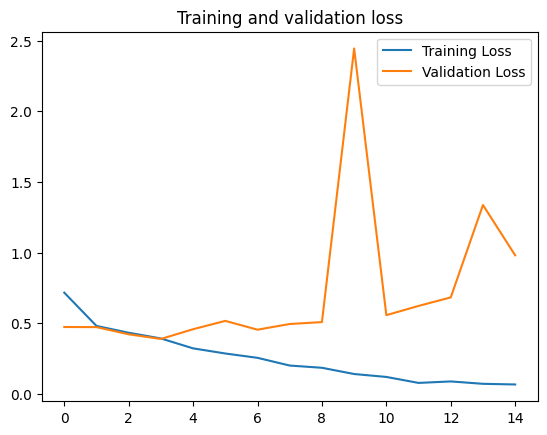

In [19]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

# Show the plots
plt.show()